In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' ## supress tensorflow-metal warnings

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
DIRECTROY = 'dataset'
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
TRAIN_SIZE = 0.8
TEST_SIZE = 0.1
VAL_SIZE = 0.1

In [65]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DIRECTROY,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)

class_names = dataset.class_names
class_names = ['Early Blight', 'Late Blight', 'Healthy']

Found 2152 files belonging to 3 classes.


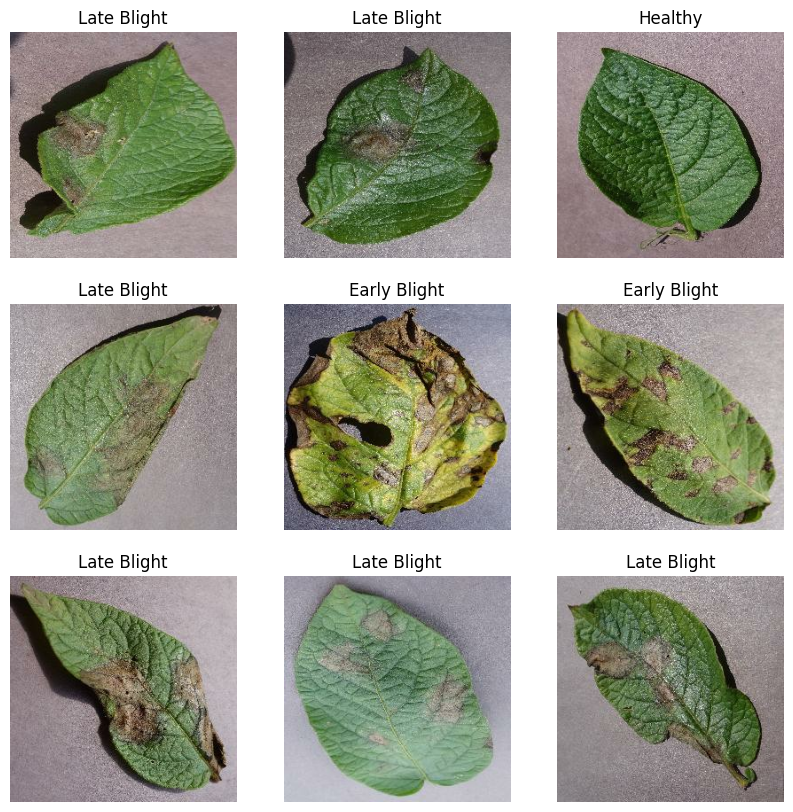

In [66]:
for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [5]:
def get_dataset_partitions(dataset, train_split=TRAIN_SIZE, val_split=VAL_SIZE, test_split=TEST_SIZE, shuffle=True, shuffle_size=10000):
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, reshuffle_each_iteration=False)

    train_size = int(train_split * len(dataset))
    val_size = int(val_split * len(dataset))

    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size)
    val_dataset = test_dataset.take(val_size)
    test_dataset = test_dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = get_dataset_partitions(dataset)

# train_dataset = dataset.take(int(len(dataset) * TRAIN_SIZE))
# test_dataset = dataset.skip(int(len(dataset) * TRAIN_SIZE))
# val_dataset = test_dataset.take(int(len(dataset) * VAL_SIZE))
# test_dataset = test_dataset.skip(int(len(val_dataset)))

In [6]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [7]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [8]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [9]:
model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (32, 128, 128, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 128, 128, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 64, 64, 32)          0         
 g2D)                                                 

In [10]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


In [12]:
scores = model.evaluate(test_dataset, verbose=1)

8/8 [==============================] - 1s 36ms/step - loss: 0.2020 - accuracy: 0.9492


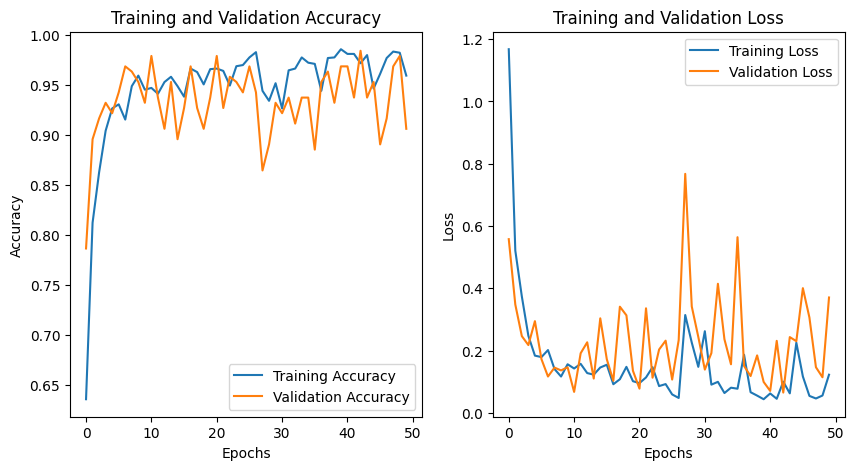

Test loss: 0.2020268440246582
Test accuracy: 0.94921875


In [20]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [109]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)

    predicted_class = class_names[np.argmax(predictions[0])]

    confidence = round(100 * (np.max(predictions[0])), 2)


    return predicted_class, confidence

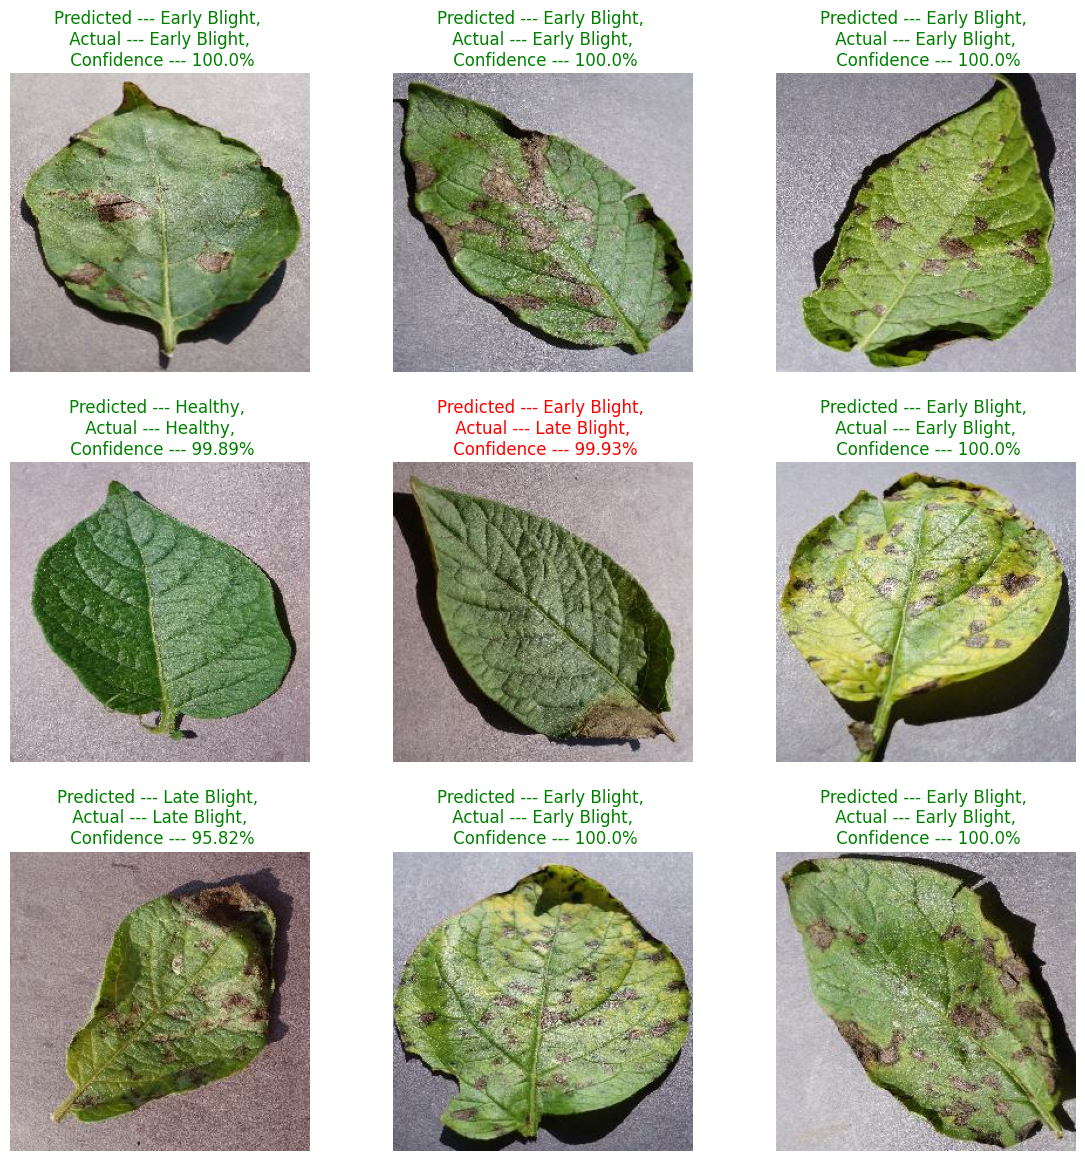

In [110]:
for images, labels in test_dataset.take(1):
    plt.figure(figsize=(14, 14))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
     
        predicted_class, confidence = predict(model, images[i])

        actual_class = class_names[labels[i]]

        if predicted_class == actual_class:
            color = 'green'
        else:
            color = 'red'

        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Predicted --- {predicted_class}, \n Actual --- {actual_class}, \n Confidence --- {confidence}%', color=color)
        plt.subplots_adjust(hspace=0.3)
        plt.axis('off')


In [76]:
model_version = 1
model.save(f'./saved_models/version_{model_version}', save_format='tf')

INFO:tensorflow:Assets written to: ./saved_models/version_1/assets


INFO:tensorflow:Assets written to: ./saved_models/version_1/assets
